In [8]:
#import matplotlib.pyplot as plt
from datetime import date
import jax
from jax import jit
import jax.numpy as jnp
import flax.linen as nn
import distrax
import jax.scipy.stats as stats
import optax

from src.resnet_groupnorm import *
from src.kernels import *
from src.cifar_train_test import *
from src.utils import *
from sklearn.metrics import classification_report

In [9]:
import orbax.checkpoint as ocp
import os
import shutil
from flax.training import orbax_utils
import orbax


In [10]:
model=ResNet(num_classes= 10,
               c_hidden= (16, 32, 64),
               num_blocks= (3, 3, 3),
               act_fn= nn.relu,
               block_class= ResNetBlock)

In [11]:
X, y = next(iter(train_loader))
print("Batch mean", X.mean(axis=(0,1,2)))
print("Batch std", X.std(axis=(0,1,2)))

Batch mean [-0.01037775 -0.02382421 -0.00971072]
Batch std [0.98627488 1.00046016 1.00506673]


In [82]:
8*16

128

images.shape: (256, 32, 32, 3)


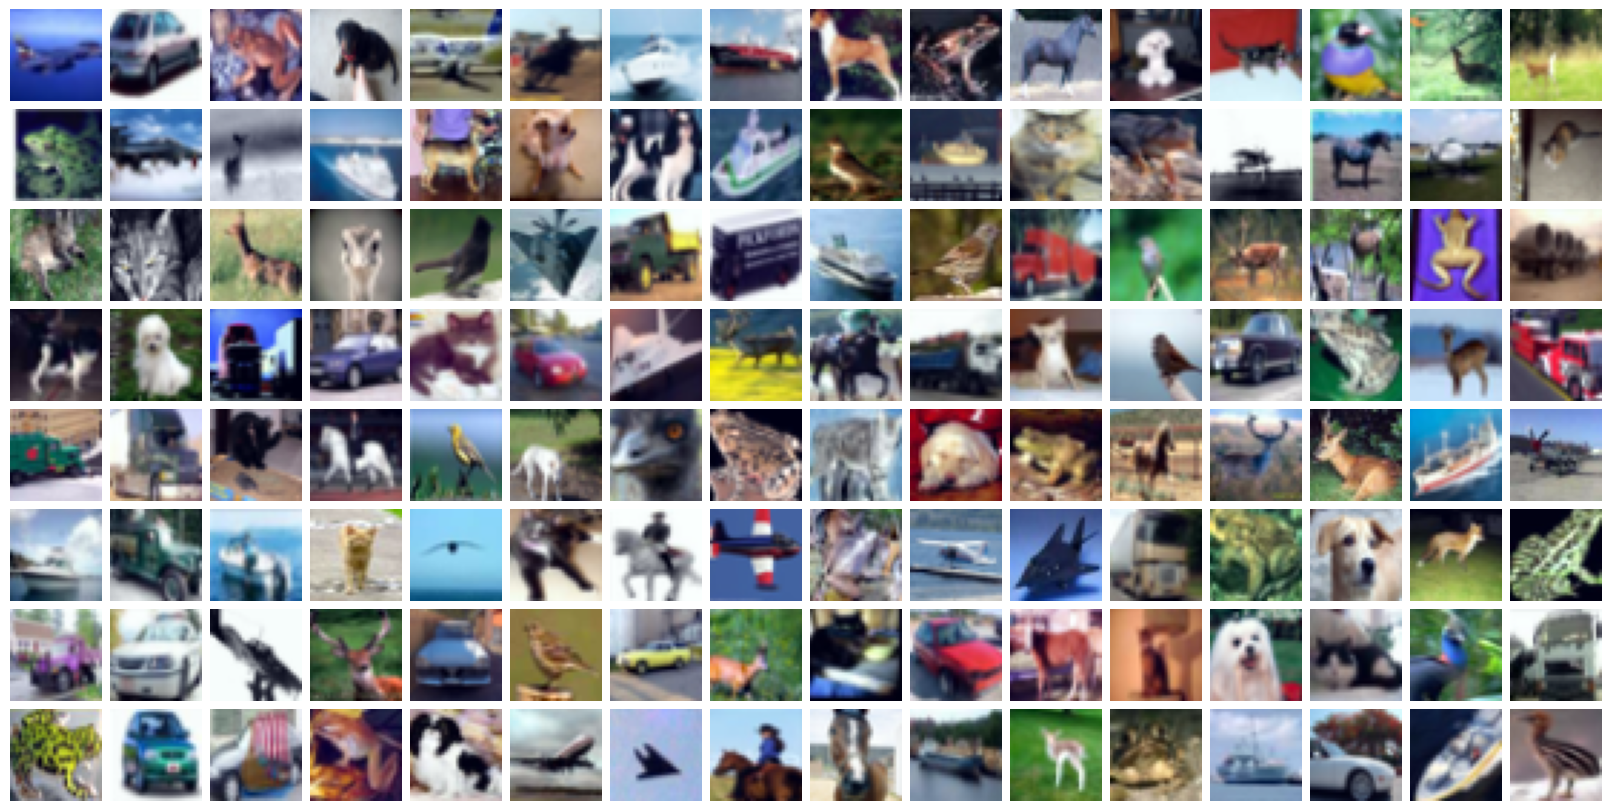

In [86]:
print('images.shape:', X.shape)
fig, axs = plt.subplots(8, 16, figsize=(16, 8), layout='constrained')
for i in range(8):
    for j in range(16):
        axs[i, j].imshow((X[i*16 + j] - X[i*16 + j].min()) / (X[i*16 + j].max() - X[i*16 + j].min()))
        axs[i, j].axis('off')
plt.savefig('cifar10_samples.pdf', bbox_inches='tight', pad_inches=0, dpi=300)



In [12]:
rngs=jax.random.PRNGKey(0)
model.tabulate(rngs, X, train=True, console_kwargs={"force_jupyter": True})

                                                  ResNet Summary                                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path                   ┃ module      ┃ inputs                  ┃ outputs               ┃ params                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│                        │ ResNet      │ - float32[256,32,32,3]  │ float32[256,10]       │                        │
│                        │             │ - train: True           │                       │                        │
├────────────────────────┼─────────────┼─────────────────────────┼───────────────────────┼────────────────────────┤
│ Conv_0                 │ Conv        │ float32[256,32,32,3]    │ float32[256,32,32,16] │ kernel:                │
│                        │             │                         │                       │ float32[3,3,3,16]      │
│                        │             │                         │                       │                        │
│                        │             │                         │                       │ 432 (1.7 KB)           │
├────────────────────────┼─────────────┼─────────────────────────┼───────────────────────┼────────────────────────┤
│ GroupNorm_0            │ GroupNorm   │ float32[256,32,32,16]   │ float32[256,32,32,16] │ bias: float32[16]      │
│                        │             │                         │                       │ scale: float32[16]     │
│                        │             │                         │                       │                        │
│                        │             │                         │                       │ 32 (128 B)             │
├────────────────────────┼─────────────┼─────────────────────────┼───────────────────────┼────────────────────────┤
│ ResNetBlock_0          │ ResNetBlock │ - float32[256,32,32,16] │ float32[256,32,32,16] │                        │
│                        │             │ - train: True           │                       │                        │
├────────────────────────┼─────────────┼─────────────────────────┼───────────────────────┼────────────────────────┤
│ ResNetBlock_0/Conv_0   │ Conv        │ float32[256,32,32,16]   │ float32[256,32,32,16] │ kernel:                │
│                        │             │                         │                       │ float32[3,3,16,16]     │
│                        │             │                         │                       │                        │
│                        │             │                         │                       │ 2,304 (9.2 KB)         │
├────────────────────────┼─────────────┼─────────────────────────┼───────────────────────┼────────────────────────┤
│ ResNetBlock_0/GroupNo… │ GroupNorm   │ float32[256,32,32,16]   │ float32[256,32,32,16] │ bias: float32[16]      │
│                        │             │                         │                       │ scale: float32[16]     │
│                        │             │                         │                       │                        │
│                        │             │                         │                       │ 32 (128 B)             │
├────────────────────────┼─────────────┼─────────────────────────┼───────────────────────┼────────────────────────┤
│ ResNetBlock_0/Conv_1   │ Conv        │ float32[256,32,32,16]   │ float32[256,32,32,16] │ kernel:                │
│                        │             │                         │                       │ float32[3,3,16,16]     │
│                        │             │                         │                       │                        │
│                        │             │                         │                       │ 2,304 (9.2 KB)         │
├────────────────────────┼─────────────┼────────────────

'\n\n'

In [13]:
def log_prior(params):
    leaves, _ = jax.tree_util.tree_flatten(params)
    flat_params = jnp.concatenate([jnp.ravel(a) for a in leaves])
    return distrax.Normal(0., 10.).log_prob(flat_params).sum()/len(train_set)

def loglikelihood(params,batch,train=True):
    X, y = batch
    outs= model.apply({'params':params}, 
                                         X,
                                         train=train)
    logits = outs 
    dist=distrax.Categorical(logits=logits)
    nll=-1.0*jnp.mean(dist.log_prob(y))
    return nll 

def log_posterior(params,batch):
    nll=loglikelihood(params,batch)
    return nll-log_prior(params)

def acc_top1(params,data_loader):
    y_pred=list()
    y_true=list()
    for batch in data_loader:
        X, y = batch
        X_batch=jnp.array(X)
        y_batch=jnp.array(y)
        prediction = model.apply({'params':params}, X_batch, train=False, mutable=False)
        y_pred.append(jnp.argmax(prediction, axis=1))
        y_true.append(y_batch)
    y_pred=jnp.concatenate(y_pred)
    y_true=jnp.concatenate(y_true)   
    return jnp.mean(y_pred == y_true)

In [14]:
from functools import partial 

grad_log_post=jax.jit(jax.value_and_grad(log_posterior))

# Train

In [15]:
curdir = os.getcwd()
ckpt_dir =os.path.join(curdir,'posterior_samples')

if os.path.exists(ckpt_dir):
    shutil.rmtree(ckpt_dir)  

options = orbax.checkpoint.CheckpointManagerOptions(save_interval_steps=len(train_set)//batch_size,max_to_keep=100, create=True)
manager = ocp.CheckpointManager(ckpt_dir, options=options)

In [16]:
learning_rate=1e-5
n_epochs=200

key = jax.random.PRNGKey(10)
key, subkey = jax.random.split(key)
variables = model.init(subkey, jnp.array(X),train=True)
params = variables['params']
momemtum=jax.tree_util.tree_map(lambda p:jnp.zeros_like(p),params)
kernel=jit(psgld_momemtum)
num_iter=0
for j in range(n_epochs):
    for i,(X,y) in enumerate(train_loader):
        #learning_rate=learning_rate*0.99
        X_batch,y_batch=jnp.array(X),jnp.array(y)
        nll,grads=grad_log_post(params,(X_batch,y_batch))
        #batch_stats=new_state['batch_stats']
        key,params,momemtum=kernel(key,params,momemtum,grads,learning_rate)
        position={'params':params}
        #samples.append(position)
        manager.save(num_iter,args=ocp.args.StandardSave(position))
        num_iter+=1
    if (j%(n_epochs//10)==0):
        logits=model.apply({'params':params},X_batch,train=False,mutable=False)
        accuracy = (logits.argmax(axis=-1) == y_batch).mean()
        nll=loglikelihood(params,(X_batch,y_batch),train=False)
        val_accuracy=acc_top1(params,val_loader)
        print('Epoch {0}, Log-likelihood : {1:8.2f}, Train Accuracy : {2:8.2f}, Val Accuracy {3:8.2f}: '.
              format(j,nll,accuracy,val_accuracy))
    

Epoch 0, Log-likelihood :     1.44, Train Accuracy :     0.50, Val Accuracy     0.44: 
Epoch 20, Log-likelihood :     0.66, Train Accuracy :     0.80, Val Accuracy     0.73: 
Epoch 40, Log-likelihood :     0.59, Train Accuracy :     0.80, Val Accuracy     0.74: 
Epoch 60, Log-likelihood :     0.37, Train Accuracy :     0.88, Val Accuracy     0.79: 
Epoch 80, Log-likelihood :     0.41, Train Accuracy :     0.84, Val Accuracy     0.79: 
Epoch 100, Log-likelihood :     0.31, Train Accuracy :     0.89, Val Accuracy     0.81: 
Epoch 120, Log-likelihood :     0.35, Train Accuracy :     0.90, Val Accuracy     0.80: 
Epoch 140, Log-likelihood :     0.33, Train Accuracy :     0.88, Val Accuracy     0.80: 
Epoch 160, Log-likelihood :     0.27, Train Accuracy :     0.93, Val Accuracy     0.82: 
Epoch 180, Log-likelihood :     0.30, Train Accuracy :     0.89, Val Accuracy     0.82: 


In [20]:
acc_top1(params,test_loader)

Array(0.8136, dtype=float32)

# Checkpoint

In [21]:
curdir = os.getcwd()
ckpt_dir =os.path.join(curdir,'posterior_samples')

options = orbax.checkpoint.CheckpointManagerOptions(save_interval_steps=len(train_set)//batch_size,max_to_keep=100, create=True)
manager = ocp.CheckpointManager(ckpt_dir, options=options)

last_ckpt=manager.all_steps()[0]
restored = manager.restore(last_ckpt)
acc_top1(restored['params'],test_loader)

Array(0.81909996, dtype=float32)

# Quantization

In [22]:
sgld_samples = [manager.restore(ckpt) for ckpt in manager.all_steps()]

In [23]:
len(sgld_samples)

100

In [24]:
stacked_samples=tree_stack(sgld_samples)
alpha=jax.tree.map(lambda p:jnp.min(p),stacked_samples)
beta=jax.tree.map(lambda p:jnp.max(p),stacked_samples)
b=8
alpha_q = 0
beta_q = 255
s=jax.tree.map(lambda a,b:generate_quantization_constants_scale(a,b,alpha_q,beta_q),alpha,beta)
z=jax.tree.map(lambda a,b:generate_quantization_constants_bias(a,b,alpha_q,beta_q),alpha,beta)

In [25]:
quantized_stacked_samples=jax.tree.map(lambda x,s,z:quantization(x,s,z,alpha_q,beta_q),stacked_samples,s,z)

In [26]:
dequantized_stacked_samples=jax.tree.map(
    lambda x,s,z:dequantization(x,s,z),quantized_stacked_samples,s,z)

In [27]:
def print_pytree(tree, name="tree"):
    """Prints the structure and values of a JAX pytree."""
    print(f"--- Printing PyTree: {name} ---")
    flattened, _ = jax.tree_util.tree_flatten_with_path(tree)
    for key_path, value in flattened:
        path_str = jax.tree_util.keystr(key_path)
        print(f"{name}{path_str}: {value}")
    print("-" * (len(name) + 22))

print_pytree(jax.tree.map(lambda p,q:jnp.linalg.norm(p-q),dequantized_stacked_samples,stacked_samples))

--- Printing PyTree: tree ---
tree['params']['Conv_0']['kernel']: 1.1105022430419922
tree['params']['Dense_0']['bias']: 0.08438737690448761
tree['params']['Dense_0']['kernel']: 1.1530232429504395
tree['params']['GroupNorm_0']['bias']: 0.08921366184949875
tree['params']['GroupNorm_0']['scale']: 0.07544708251953125
tree['params']['ResNetBlock_0']['Conv_0']['kernel']: 3.0762150287628174
tree['params']['ResNetBlock_0']['Conv_1']['kernel']: 3.0284159183502197
tree['params']['ResNetBlock_0']['GroupNorm_0']['bias']: 0.08275745064020157
tree['params']['ResNetBlock_0']['GroupNorm_0']['scale']: 0.08005981892347336
tree['params']['ResNetBlock_0']['GroupNorm_1']['bias']: 0.07329937815666199
tree['params']['ResNetBlock_0']['GroupNorm_1']['scale']: 0.08020941913127899
tree['params']['ResNetBlock_1']['Conv_0']['kernel']: 2.737917423248291
tree['params']['ResNetBlock_1']['Conv_1']['kernel']: 2.877387285232544
tree['params']['ResNetBlock_1']['GroupNorm_0']['bias']: 0.1025465577840805
tree['params']['Re

In [28]:
dequantized_samples=tree_unstack(dequantized_stacked_samples)

In [29]:
fp32_size=sum(jax.tree.flatten(jax.tree.map(lambda p:p.nbytes,stacked_samples))[0])*1e-6

In [30]:
int8_size=sum(jax.tree.flatten(jax.tree.map(lambda p:p.nbytes,quantized_stacked_samples))[0])*1e-6

# Pruebas Clasificación

In [31]:
def ensemble_acc_top1(params,data_loader):
    y_pred=list()
    y_true=list()
    for batch in data_loader:
        X, y = batch
        X_batch=jnp.array(X)
        y_batch=jnp.array(y)
        prediction = model.apply({'params':params}, X_batch, train=False)
        y_pred.append(prediction)
        y_true.append(y_batch)
    y_pred=jnp.concatenate(y_pred)
    y_true=jnp.concatenate(y_true)   
    return y_pred,y_true

In [32]:
len(sgld_samples)

100

In [33]:
ensemble_pred=list()
for sample in sgld_samples:
    y_pred,y_true = ensemble_acc_top1(sample['params'],test_loader)
    ensemble_pred.append(y_pred)

In [34]:
ensemble_pred=jnp.stack(ensemble_pred)

In [49]:
mean_pred=jnp.median(ensemble_pred,axis=0)
five_num_pred=jnp.percentile(ensemble_pred,0.05,axis=0)
ninety_five_num_pred=jnp.percentile(ensemble_pred,95.0,axis=0)

In [50]:
from sklearn.metrics import classification_report

print(classification_report(np.array(y_true), np.asarray(mean_pred.argmax(axis=1))))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1000
           1       0.92      0.93      0.93      1000
           2       0.83      0.79      0.81      1000
           3       0.74      0.67      0.70      1000
           4       0.82      0.88      0.85      1000
           5       0.84      0.73      0.78      1000
           6       0.81      0.92      0.86      1000
           7       0.89      0.88      0.88      1000
           8       0.92      0.91      0.92      1000
           9       0.90      0.90      0.90      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [51]:
print(classification_report(np.array(y_true), np.asarray(five_num_pred.argmax(axis=1))))

              precision    recall  f1-score   support

           0       0.81      0.86      0.84      1000
           1       0.93      0.91      0.92      1000
           2       0.75      0.81      0.78      1000
           3       0.67      0.68      0.67      1000
           4       0.85      0.80      0.82      1000
           5       0.82      0.70      0.75      1000
           6       0.84      0.88      0.86      1000
           7       0.87      0.88      0.87      1000
           8       0.91      0.90      0.90      1000
           9       0.88      0.90      0.89      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



In [52]:
print(classification_report(np.array(y_true), np.asarray(ninety_five_num_pred.argmax(axis=1))))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1000
           1       0.92      0.93      0.93      1000
           2       0.84      0.76      0.80      1000
           3       0.78      0.63      0.70      1000
           4       0.83      0.86      0.84      1000
           5       0.78      0.78      0.78      1000
           6       0.79      0.93      0.85      1000
           7       0.89      0.88      0.89      1000
           8       0.92      0.91      0.92      1000
           9       0.88      0.92      0.90      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



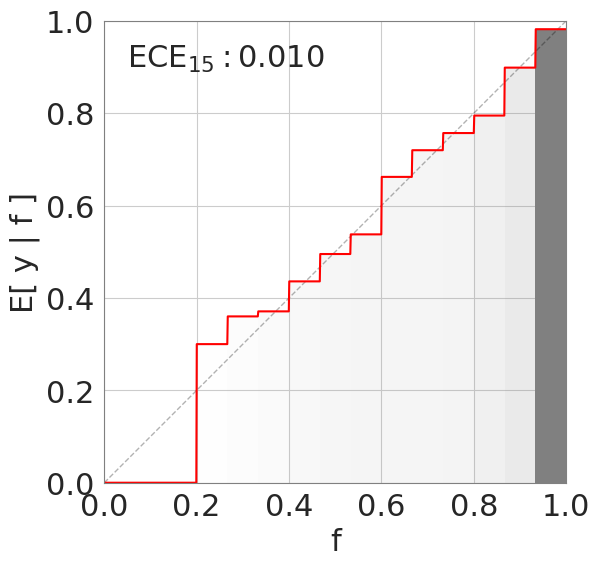

In [88]:
import relplot 

conf, acc = relplot.multiclass_logits_to_confidences(mean_pred, y_true) # reduce to binary setting
relplot.rel_diagram_binned(f=conf, y=acc) # plot confidence calibration diagram
relplot.smECE(f=conf, y=acc) # compute smECE of confidence calibration
plt.savefig('ece_mean_32.pdf', bbox_inches='tight', pad_inches=0, dpi=300)

In [58]:
conf, acc = relplot.multiclass_logits_to_confidences(mean_pred, y_true) # reduce to binary setting
ece_mean=relplot.smECE(f=conf, y=acc) # compute smECE of confidence calibration
print("50% ECE: {0:0.2f}".format(ece_mean))
conf, acc = relplot.multiclass_logits_to_confidences(five_num_pred, y_true) # reduce to binary setting
ece_five=relplot.smECE(f=conf, y=acc) # compute smECE of confidence calibration
print("5% ECE: {0:0.2f}".format(ece_five))
conf, acc = relplot.multiclass_logits_to_confidences(ninety_five_num_pred, y_true) # reduce to binary setting
ece_ninety_five=relplot.smECE(f=conf, y=acc) # compute smECE of confidence calibration
print("95% ECE: {0:0.2f}".format(ece_ninety_five))

50% ECE: 0.01
5% ECE: 0.02
95% ECE: 0.02


# Quantization Calibration

In [59]:
quantized_ensemble_pred=list()
for sample in dequantized_samples:
    y_pred,y_true = ensemble_acc_top1(sample['params'],test_loader)
    quantized_ensemble_pred.append(y_pred)

In [63]:
len(quantized_ensemble_pred)

100

In [90]:
quantized_ensemble_pred=jnp.stack(quantized_ensemble_pred)
qmean_pred=jnp.mean(quantized_ensemble_pred,axis=0)
print(classification_report(np.array(y_true), np.asarray(qmean_pred.argmax(axis=1))))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1000
           1       0.92      0.94      0.93      1000
           2       0.82      0.80      0.81      1000
           3       0.77      0.67      0.71      1000
           4       0.85      0.88      0.86      1000
           5       0.83      0.76      0.79      1000
           6       0.81      0.93      0.86      1000
           7       0.90      0.89      0.90      1000
           8       0.92      0.92      0.92      1000
           9       0.90      0.91      0.91      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [92]:
q_five_pred=jnp.quantile(quantized_ensemble_pred,0.05,axis=0)
q_ninetyfive_pred=jnp.quantile(quantized_ensemble_pred,0.95,axis=0)

print(classification_report(np.array(y_true), np.asarray(q_five_pred.argmax(axis=1))))


              precision    recall  f1-score   support

           0       0.82      0.87      0.84      1000
           1       0.92      0.93      0.92      1000
           2       0.78      0.79      0.79      1000
           3       0.73      0.65      0.68      1000
           4       0.85      0.83      0.84      1000
           5       0.81      0.74      0.77      1000
           6       0.80      0.91      0.85      1000
           7       0.88      0.88      0.88      1000
           8       0.91      0.90      0.91      1000
           9       0.88      0.90      0.89      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [93]:
print(classification_report(np.array(y_true), np.asarray(q_ninetyfive_pred.argmax(axis=1))))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1000
           1       0.92      0.93      0.92      1000
           2       0.83      0.76      0.79      1000
           3       0.78      0.62      0.69      1000
           4       0.83      0.85      0.84      1000
           5       0.77      0.78      0.78      1000
           6       0.78      0.93      0.85      1000
           7       0.90      0.88      0.89      1000
           8       0.93      0.91      0.92      1000
           9       0.88      0.92      0.90      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.84     10000
weighted avg       0.85      0.85      0.84     10000



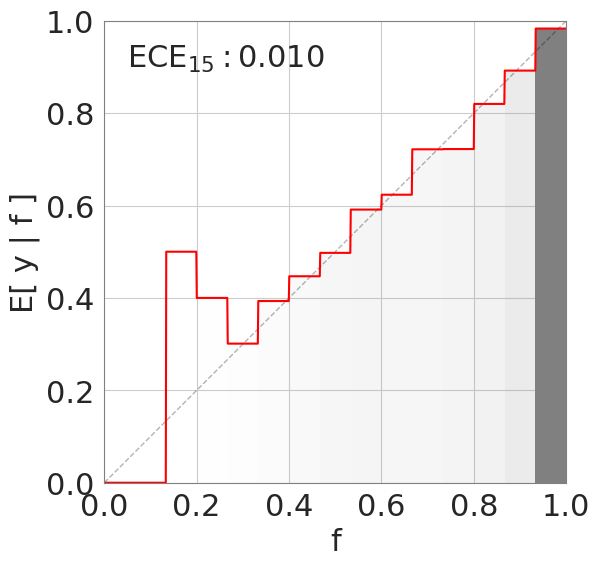

In [89]:
conf, acc = relplot.multiclass_logits_to_confidences(qmean_pred, y_true) # reduce to binary setting
relplot.rel_diagram_binned(f=conf, y=acc) # plot confidence calibration diagram
relplot.smECE(f=conf, y=acc) # compute smECE of confidence calibration
plt.savefig('ece_mean_8.pdf', bbox_inches='tight', pad_inches=0, dpi=300)

# Metricas de Muestreo

In [94]:
from kernax import SteinThinning

In [95]:
def ensemble_log_probs(params,data_loader):
    for batch in data_loader:
        X, y = batch
        X_batch=jnp.array(X)
        y_batch=jnp.array(y)
        nll,grads=grad_log_post(params,(X_batch,y_batch))
        break
    return nll,grads

In [96]:
nll_list=list()
grads_list=list()
for sample in sgld_samples:
    ll,gg=ensemble_log_probs(sample['params'],test_loader)
    nll_list.append(ll)
    grads_list.append(gg)

In [97]:
stacked_grads=tree_stack(grads_list)
flatten_scores=jax.tree.map(lambda p:p.reshape(100,-1),stacked_grads)

In [98]:
from kernax.utils import median_heuristic

flatten_stacked_samples=jax.tree.map(lambda p:p.reshape(100,-1),stacked_samples)
length_scales=jax.tree.map(lambda p:median_heuristic(p),flatten_stacked_samples)

In [99]:
indices=jax.tree.map(lambda x,s,l:SteinThinning(x,s,l)(30),flatten_stacked_samples['params'],flatten_scores,length_scales['params'])

In [100]:
all_indices=jnp.stack(jax.tree_util.tree_leaves(indices))
voted_indices,counts=jnp.unique(all_indices,return_counts=True)
thinned_indices=[voted_indices[i] for i in counts.argsort(descending=True)][:30]
thinned_indices=jnp.stack(thinned_indices)
thinned_samples=[sgld_samples[i] for i in thinned_indices]

In [101]:
thinned_ensemble_pred=list()
for sample in thinned_samples:
    y_pred,y_true = ensemble_acc_top1(sample['params'],test_loader)
    thinned_ensemble_pred.append(y_pred)

In [102]:
from sklearn.metrics import classification_report

thinned_ensemble_pred=jnp.stack(thinned_ensemble_pred)
thinned_pred=jnp.median(thinned_ensemble_pred,axis=0)
print(classification_report(np.array(y_true), np.asarray(thinned_pred.argmax(axis=1))))

              precision    recall  f1-score   support

           0       0.82      0.90      0.85      1000
           1       0.93      0.93      0.93      1000
           2       0.84      0.75      0.79      1000
           3       0.74      0.65      0.69      1000
           4       0.81      0.88      0.84      1000
           5       0.83      0.72      0.77      1000
           6       0.79      0.93      0.85      1000
           7       0.87      0.89      0.88      1000
           8       0.92      0.91      0.91      1000
           9       0.91      0.90      0.90      1000

    accuracy                           0.84     10000
   macro avg       0.85      0.85      0.84     10000
weighted avg       0.85      0.84      0.84     10000



In [103]:
five_thinned_pred=jnp.quantile(thinned_ensemble_pred,0.05,axis=0)
print(classification_report(np.array(y_true), np.asarray(five_thinned_pred.argmax(axis=1))))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1000
           1       0.91      0.93      0.92      1000
           2       0.78      0.80      0.79      1000
           3       0.69      0.70      0.69      1000
           4       0.85      0.84      0.84      1000
           5       0.83      0.70      0.76      1000
           6       0.84      0.89      0.86      1000
           7       0.88      0.88      0.88      1000
           8       0.89      0.92      0.90      1000
           9       0.89      0.89      0.89      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [104]:
ninety_five_num_pred_thinned_pred=jnp.quantile(thinned_ensemble_pred,0.95,axis=0)
print(classification_report(np.array(y_true), np.asarray(ninety_five_num_pred_thinned_pred.argmax(axis=1))))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1000
           1       0.91      0.92      0.92      1000
           2       0.84      0.75      0.79      1000
           3       0.75      0.66      0.70      1000
           4       0.81      0.86      0.83      1000
           5       0.81      0.74      0.78      1000
           6       0.81      0.93      0.86      1000
           7       0.90      0.88      0.89      1000
           8       0.93      0.89      0.91      1000
           9       0.85      0.91      0.88      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



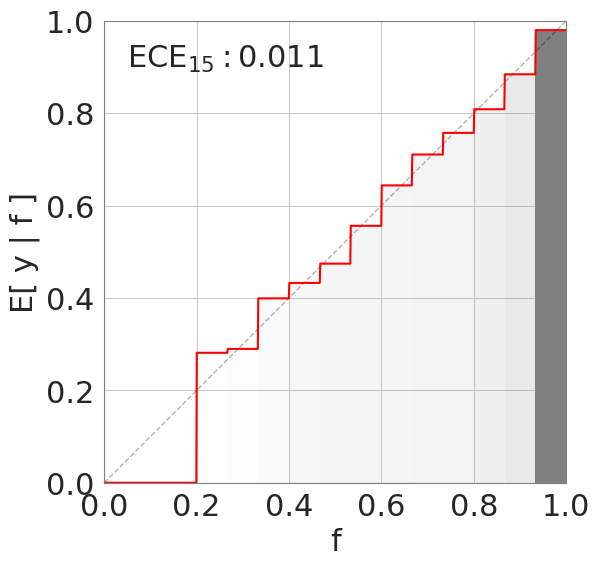

In [105]:
conf, acc = relplot.multiclass_logits_to_confidences(thinned_pred, y_true) # reduce to binary setting
relplot.rel_diagram_binned(f=conf, y=acc) # plot confidence calibration diagram
relplot.smECE(f=conf, y=acc) # compute smECE of confidence calibration
plt.savefig('ece_mean_ksd.pdf', bbox_inches='tight', pad_inches=0, dpi=300)

In [106]:
stacked_thinned_samples=tree_stack(thinned_samples)
thinned_size=sum(jax.tree.flatten(jax.tree.map(lambda p:p.nbytes,stacked_thinned_samples))[0])*1e-6

In [107]:
print('Tamaño Muestras FP32 : {0:.2f}Mb'.format(fp32_size))
print('Tamaño Muestras INT8 : {0:.2f}Mb'.format(int8_size))
print('Tamaño Muestras Thinning : {0:.2f}Mb'.format(thinned_size))

Tamaño Muestras FP32 : 108.95Mb
Tamaño Muestras INT8 : 27.24Mb
Tamaño Muestras Thinning : 32.69Mb


# Thinning + Quantization

In [108]:
alpha=jax.tree.map(lambda p:jnp.min(p),stacked_thinned_samples)
beta=jax.tree.map(lambda p:jnp.max(p),stacked_thinned_samples)
b=8
alpha_q = 0
beta_q = 255
s=jax.tree.map(lambda a,b:generate_quantization_constants_scale(a,b,alpha_q,beta_q),alpha,beta)
z=jax.tree.map(lambda a,b:generate_quantization_constants_bias(a,b,alpha_q,beta_q),alpha,beta)

In [109]:
quantized_thinned_stacked_samples=jax.tree.map(lambda x,s,z:quantization(x,s,z,alpha_q,beta_q),stacked_thinned_samples,s,z)
dequantized_thinned_stacked_samples=jax.tree.map(
    lambda x,s,z:dequantization(x,s,z),quantized_thinned_stacked_samples,s,z)
dequantized_thinned_samples=tree_unstack(dequantized_thinned_stacked_samples)
#dequantized_thinned_samples=tree_unstack(dequantized_thinned_stacked_samples)

In [110]:
quantized_thinned_size=sum(jax.tree.flatten(jax.tree.map(lambda p:p.nbytes,quantized_thinned_stacked_samples))[0])*1e-6

In [115]:
quantized_thinned_pred=list()
for sample in dequantized_thinned_samples:
    y_pred,y_true = ensemble_acc_top1(sample['params'],test_loader)
    quantized_thinned_pred.append(y_pred)

In [116]:
quantized_thinned_pred=jnp.stack(quantized_thinned_pred)
median_thinned_pred=jnp.median(quantized_thinned_pred,axis=0)
print(classification_report(np.array(y_true), np.asarray(median_thinned_pred.argmax(axis=1))))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1000
           1       0.93      0.93      0.93      1000
           2       0.83      0.75      0.79      1000
           3       0.74      0.64      0.69      1000
           4       0.80      0.89      0.84      1000
           5       0.83      0.72      0.77      1000
           6       0.80      0.92      0.86      1000
           7       0.87      0.89      0.88      1000
           8       0.91      0.91      0.91      1000
           9       0.89      0.91      0.90      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [117]:
five_quantized_thinned_pred=jnp.quantile(quantized_thinned_pred,0.05,axis=0)
print(classification_report(np.array(y_true), np.asarray(five_quantized_thinned_pred.argmax(axis=1))))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1000
           1       0.91      0.93      0.92      1000
           2       0.79      0.78      0.79      1000
           3       0.66      0.73      0.69      1000
           4       0.85      0.83      0.84      1000
           5       0.83      0.70      0.76      1000
           6       0.84      0.89      0.86      1000
           7       0.88      0.87      0.88      1000
           8       0.89      0.92      0.91      1000
           9       0.89      0.89      0.89      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [118]:
ninety_quantized_thinned_pred=jnp.quantile(quantized_thinned_pred,0.05,axis=0)
print(classification_report(np.array(y_true), np.asarray(ninety_quantized_thinned_pred.argmax(axis=1))))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1000
           1       0.91      0.93      0.92      1000
           2       0.79      0.78      0.79      1000
           3       0.66      0.73      0.69      1000
           4       0.85      0.83      0.84      1000
           5       0.83      0.70      0.76      1000
           6       0.84      0.89      0.86      1000
           7       0.88      0.87      0.88      1000
           8       0.89      0.92      0.91      1000
           9       0.89      0.89      0.89      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



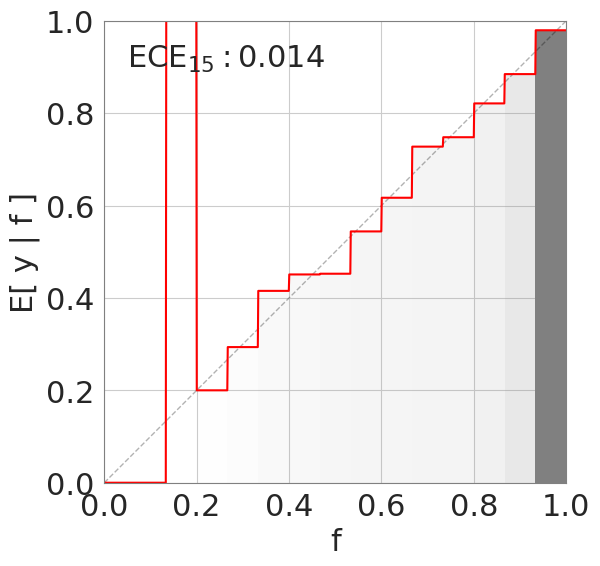

In [120]:
conf, acc = relplot.multiclass_logits_to_confidences(median_thinned_pred, y_true) # reduce to binary setting
relplot.rel_diagram_binned(f=conf, y=acc) # plot confidence calibration diagram
relplot.smECE(f=conf, y=acc) # compute smECE of confidence calibration
plt.savefig('ece_mean_qksd.pdf', bbox_inches='tight', pad_inches=0, dpi=300)

In [191]:
print('Tamaño Muestras FP32 : {0:.2f}Mb'.format(fp32_size))
print('Tamaño Muestras INT8 : {0:.2f}Mb'.format(int8_size))
print('Tamaño Muestras Thinning : {0:.2f}Mb'.format(thinned_size))
print('Tamaño Muestras Quantization+Thinning : {0:.2f}Mb'.format(quantized_thinned_size))

Tamaño Muestras FP32 : 108.95Mb
Tamaño Muestras INT8 : 27.24Mb
Tamaño Muestras Thinning : 32.69Mb
Tamaño Muestras Quantization+Thinning : 8.17Mb
